# Applied Statistics - Project

Course: HDip in Computing in Data Analytics <br>
Module: Applied Statistics <br>
Lecturer: Ian McLoughlin <br>
 
A notebook which contains the work on the project for the above module (Sept 2024).

Student: Eilis Donohue (G00006088)

## Table of Contents
- Project Description
- Dataset Description
- $t$-test
- ANOVA test
- Further Tests
- References

## Project Description
In this project, you will analyze the [PlantGrowth R dataset](https://vincentarelbundock.github.io/Rdatasets/csv/datasets/PlantGrowth.csv).
You will find [a short description](https://vincentarelbundock.github.io/Rdatasets/doc/datasets/PlantGrowth.html) of it on [Vicent Arel-Bundock's Rdatasets page](https://vincentarelbundock.github.io/Rdatasets/).
The dataset contains two main variables, a treatment group and the weight of plants within those groups.

Your task is to perform t-tests and ANOVA on this dataset while describing the dataset and explaining your work.
In doing this you should:

1. Download and save the dataset to your repository.

2. Describe the data set in your notebook.

3. Describe what a t-test is, how it works, and what the assumptions are.

3. Perform a t-test to determine whether there is a significant difference between the two treatment groups `trt1` and `trt2`.

4. Perform ANOVA to determine whether there is a significant difference between the three treatment groups `ctrl`, `trt1`, and `trt2`.

5. Explain why it is more appropriate to apply ANOVA rather than several t-tests when analyzing more than two groups.

___



In [18]:
# Import required python packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
# To perform a power calculation
from statsmodels.stats.power import FTestAnovaPower

In [26]:
# Read in the data and display first 5 rows
data = pd.read_csv('data/plant_growth.csv')
data.head()

,rownames,weight,group
0,1,4.17,ctrl
1,2,5.58,ctrl
2,3,5.18,ctrl
3,4,6.11,ctrl
4,5,4.50,ctrl


## Dataset Description


In [25]:
# Get the unique group names from the group column
group_names = data["group"].unique()  
print(group_names)

['ctrl' 'trt1' 'trt2']


In [ ]:
# Show the dtype and number of observations including nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  30 non-null     int64  
 1   weight    30 non-null     float64
 2   group     30 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 852.0+ bytes


### Feature Description
 - The dataset has 30 samples with 3 features: Rownames (numeric), Weight (numeric) and group(string).
 - The rowname appears as a sequential index feature and will not be of use for statistical analysis.
 - The group feature is a categorical variable (nominal) with 3 unique values: 'ctrl', 'trt1' and 'trt2'. From the dataset description, it is understood that these represent a control and two different treatment conditions [2].
 - The weight feature represents the plant weight and is a continuous variable (ratio) which is quantitative numeric and will be used for statistical analysis. 

In [ ]:
# Extract the weight data for each group
for item in group_names:
    # Extract the data related to one group
    weight_data = data[data["group"] == item].copy()

In [ ]:
# Remove rownmames columns
weight_data = data.drop(columns='rownames')
weight_data.head()

,weight,group
0,4.17,ctrl
1,5.58,ctrl
2,5.18,ctrl
3,6.11,ctrl
4,4.50,ctrl


In [ ]:
# Drop the weight column for some statistical analysis
weight_data.drop(columns = "group", inplace=True)

Entire dataset statistics: 
        weight
count   30.00
mean     5.07
std      0.70
min      3.59
25%      4.55
50%      5.15
75%      5.53
max      6.31 

Group statistics: 
       weight                                   
       count mean  std  min  25%  50%  75%  max
group                                          
ctrl   10.00 5.03 0.58 4.17 4.55 5.15 5.29 6.11
trt1   10.00 4.66 0.79 3.59 4.21 4.55 4.87 6.03
trt2   10.00 5.53 0.44 4.92 5.27 5.44 5.73 6.31


In [ ]:
# Get the basic statistical measures of the dataset 
# Set the pandas table float format
pd.options.display.float_format = '{:.2f}'.format

# Display the basic statistics of the overall dataset and each group
print(f'Entire dataset statistics: \n {weight_data.describe()} \n')
print(f'Group statistics: \n {weight_data.groupby('group').describe()}')


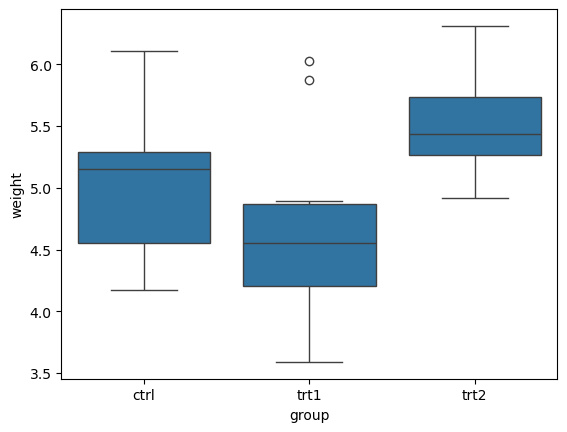

In [32]:
# Seaborn boxplot
sns.boxplot(x='group', y='weight', data=data, whis=1.5)
plt.show()

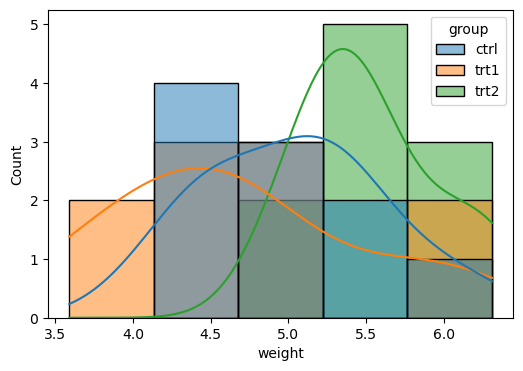

In [ ]:
# Generate Seaborn histograms
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=data, x='weight', hue='group', bins=5, kde=True);

### Shapiro-Wilk Test

The Shapiro-Wilk test is a test of normality. The null hypothesis of the test is that the data is normally distributed. It is useful to verify the assumption of normality given the small sample size for each group.   

In [8]:
# Shapiro wilk test for normality on each group
print('Shapiro-Wilk Test for Normality')
stat_c, p_c = stats.shapiro(weight_data['weight'][weight_data['group'] == 'ctrl'])
print('Ctrl group: stat=%.3f, p=%.3f' % (stat_c, p_c))
stat_t1, p_t1 = stats.shapiro(weight_data['weight'][weight_data['group'] == 'trt1'])
print('Trt1 group: stat=%.3f, p=%.3f' % (stat_t1, p_t1))
stat_t2, p_t2 = stats.shapiro(weight_data['weight'][weight_data['group'] == 'trt2'])
print('Trt2 group: stat=%.3f, p=%.3f' % (stat_t2, p_t2))

Shapiro-Wilk Test for Normality
Ctrl group: stat=0.957, p=0.747
Trt1 group: stat=0.930, p=0.452
Trt2 group: stat=0.941, p=0.564


The shapiro wilk test suggests that **the null hypothesis may not be rejected**, i.e., that the data is normally distributed (p>0.05).

## $t$-test

### What is the $t$-test?
The t-test is a statistical test used to determine if there is a significant difference between the means of two groups. The null hypothesis under consideration is that the means of two groups are the same or that there is no statistically significant difference between them [4, 10]. 

A t-test returns a t-value which is a measure of the difference between the means of the two groups relative to the variance of the data. For an independent t-test conducted on 2 groups of equal size, the formula for the t-value is [4]:

$ t = \frac{\bar{X}_1-\bar{X}_2}{s_p\sqrt \frac{2}{n}} $ where, 

$ s_p = \sqrt \frac{s_{X_1}^2 + s_{X_2}^2}{2} $

Here, $\bar{X}_1 $ and $\bar{X}_2 $ are the average of group 1 and group 2, $ s_p $ is the pooled standard deviation. $s_{X_1}$ and $s_{X_2}$ are the unbiased estimators of the population variance) and n is the degrees of freedom, in this case the number of samples in the group [4].

The p-value is the probability that the null hypothesis is true. A low p-value (usually less than 0.05) indicates that the null hypothesis can be rejected and that there is a statistically significant difference between the means of the datasets.

### Assumptions of the $t$-test [10]
- The data is on a continuous scale.
- The two categorical groups are independent.
- For the independent t-test, that the observations in each group are independent, i.e., there is no relationship between them. 
- The data is normally distributed
- There are no significant outliers
- The variance of the two groups is equal (homogeneity of variances).

It should be noted from the boxplot above that trt1 group has some outliers (lying outside $1.5 \times IQR$ in this case). This affects the standard deviation of this group and skews the distribution as seen in the histogram plots.

### $t$-test to compare Treatment 1 and Treatment 2

An independent $t$-test to compare treatment 1 and treatment 2 is performed below. As the samples in the control and 2 treatment groups are not related to one another, then the independent $t$-test is appropriate.

In [9]:
# Extract the data for the treatment groups
trt1_data = np.array(data[data['group'] == 'trt1']['weight'])
trt2_data = np.array(data[data['group'] == 'trt2']['weight'])

In [ ]:
# An independent t-test to compare the means of trt 1 and trt 2
stats.ttest_ind(trt1_data, trt2_data)

TtestResult(statistic=-3.0100985421243616, pvalue=0.0075184261182198574, df=18.0)

The $t$-test result has a p-value of 0.0075 indicating that the null hypothesis can be rejected (there is a statistically significant difference between the means of Treatment 1 and Treatment 2).

## ANOVA (Analysis of Variance) Test

The ANOVA (Analysis of Variance) test is a statistical test developed by Ronald Fisher and is used to determine if there are statistically significant differences between the means of three or more independent groups [9]. 

The null hypothesis is that the means of the groups are equal or that there is no statistically significant difference between them. The ANOVA test returns an $f$-value and a $p$-value. A $p$-value below the threshold (generally <0.05) indicates that the null hypothesis can be rejected and that there is a statistically significant difference between the means of the groups.

### Assumptions of the ANOVA test [12]

- The data is on a continuous scale.
- The two or more categorical groups are independent.
- There is no relationship between the observations in each group.
- The data is normally distributed
- There are no significant outliers
- The variance of the groups is equal (homogeneity of variances).

Note:

- From the Shapiro-Wilk test above, the null hypothesis that the data is normally distributed cannot be rejected (p>0.05).

- The standard deviations of all three groups are similar with trt1 having the highest standard deviation. The dataset is deemed to satisfy the assumptions of the ANOVA test. There are tests which may be carried out to confirm this assumption

- The dataset however is relatively small with only 10 samples per class - this may affect the power of the test, i.e., the ability of the test to reject the null hypothesis in the case that it is actually false (i.e., avoid a type II error).

In [11]:
print(f'Group statistics: \n {weight_data.groupby('group').describe()}')

Group statistics: 
       weight                                   
       count mean  std  min  25%  50%  75%  max
group                                          
ctrl   10.00 5.03 0.58 4.17 4.55 5.15 5.29 6.11
trt1   10.00 4.66 0.79 3.59 4.21 4.55 4.87 6.03
trt2   10.00 5.53 0.44 4.92 5.27 5.44 5.73 6.31


In [12]:
# Do ANOVA test of the three groups to determine statistical significance/difference of means
# Isolate the ctrl data

ctrl_data = np.array(data[data['group'] == 'ctrl']['weight'])

f, p = stats.f_oneway(ctrl_data, trt1_data, trt2_data)
f, p

(4.846087862380136, 0.0159099583256229)

The $p$-value of the ANOVA test considering the three groups is 0.015 which is below the threshold of 0.05. This would lead us to reject the null hypothesis that the means of the three groups are the same. So it is judged that there is a statistically significant difference between the means of the groups. 

A post-hoc test such as Tukey's HSD test may be carried out to determine which groups are significantly different from each other [5].

### Perform post-hoc Tukey test 

In [13]:
# Tukey hsd test
# Tukey's HSD.
res = stats.tukey_hsd(ctrl_data, trt1_data, trt2_data)

# Show results
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.371     0.391    -0.320     1.062
 (0 - 2)     -0.494     0.198    -1.185     0.197
 (1 - 0)     -0.371     0.391    -1.062     0.320
 (1 - 2)     -0.865     0.012    -1.556    -0.174
 (2 - 0)      0.494     0.198    -0.197     1.185
 (2 - 1)      0.865     0.012     0.174     1.556



- The tukey test shows higher p-value between the control and treatment1 than between the control and treatment2, suggesting a greater effect of treatment 1 than treatment 2.  

- It also indicates that there is no statistical difference between treatment 1 and treatment 2 (0.012<0.05). The inability of the test to reject the null hypothesis may be due to the larger standard deviation of treatment 1 compared to treatment 2. 

- So while the treatments are deemed to be statistically different from the control group, they are not statistically different from each other.

## Further Tests

A test for the equality of variances, such as **Levene's test** (to verify the assumption that the standard deviations are equal) may be carried out to confirm the results above for the ANOVA test [7, 8]. 

In addition, given the existence of a control group and the assumption that the variances are equal, **Dunnett's test** may be carried out [6]. Dunnett's test is a multiple comparison test which compares the control group to the treatment groups.

In [14]:
# Levene's test
f, p = stats.levene(ctrl_data, trt1_data, trt2_data)
print(f'Levene f-value:{f}, p-value:{p}')


Levene f-value:1.1191856948703909, p-value:0.3412266241254737


Levene's test would suggest that we may accept that null hypothesis that the variances are equal (p>0.05).

In [15]:
# Perform Dunnett test
res = stats.dunnett(trt1_data, trt2_data, control=ctrl_data)
print(f'Dunnett f-value:{res}')

Dunnett f-value:Dunnett's test (95.0% Confidence Interval)
Comparison               Statistic  p-value  Lower CI  Upper CI
 (Sample 0 - Control)     -1.331     0.323    -1.021     0.279
 (Sample 1 - Control)      1.772     0.154    -0.156     1.144



Dunnett's comparison test comparing the effect of the treatments relative to the control group confirm the findings above from the ANOVA test. Both treatments show a statistically significant effect with treatment 1 being more significant that treatment 2.

### Performing a Power Test

The power of a test is calculated to assess the probability of detect significant different results between groups. This gives an indication of the likelihood of a type II error, i.e., that there was a significant difference but the test result implied that there was not [14].

The power of a test is affected by [14]:

+ the effect size (what is the difference between the groups or the difference you wish to detect)
+ the sample size
+ the significance level (alpha)

The statsmodel package allows for a an ANOVA Power test [13]. The effect size has been calculated as the ratio of the difference between the min and max means of the 3 groups and the pooled standard deviation [15]. <br>

The power of the test is calculated as 0.92 which is considered a good power level [14].

This is just an indication of the power of the test.

In [ ]:
# Calculate the parameters for the test FTestAnovaPower

# Take the mean difference as the difference between the largest and smallest means [15]
max_mean = np.max([ctrl_data.mean(), trt2_data.mean(), trt1_data.mean()])
min_mean = np.min([ctrl_data.mean(), trt2_data.mean(), trt1_data.mean()]) 

mean_diff = max_mean - min_mean

# Calculate the pooled standard deviation
pooled_std_dev = np.sqrt((ctrl_data.std()**2 + trt2_data.std()**2 + trt1_data.std()**2) / 3)

n_groups = 3     # Number of groups
n_samples = 10  # Number of samples per group

# Estimate the effect size [15]
effect_size = mean_diff / pooled_std_dev

# Perform power analysis
power_analysis = FTestAnovaPower()
power = power_analysis.solve_power(effect_size=effect_size, nobs=n_samples, alpha=0.05, k_groups=n_groups)

# Calculate the probability of Type II error (beta)
beta = 1 - power

print(f"Power of the test: {power:.4f}")
print(f"Probability of Type II error (beta): {beta:.4f}")


Power of the test: 0.9151
Probability of Type II error (beta): 0.0849


## References

1. Bundock, V. Plant Growth Dataset https://vincentarelbundock.github.io/Rdatasets/csv/datasets/PlantGrowth.csv 
2. Bundock, V. Description of the Plant Growth Dataset https://vincentarelbundock.github.io/Rdatasets/doc/datasets/PlantGrowth.html 
3. Bundock, V. Further description of the Plant Growth Dataset [Online] Available: https://vincentarelbundock.github.io/Rdatasets/ 
4. Wikipedia (2024) Student's t-test [Online] Available: https://en.wikipedia.org/wiki/Student%27s_t-test 
5. Scipy (2024) Tukey HSD test [Online]. Available: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.tukey_hsd.html#tukey-hsd
6.  Scipy (2024) Dunnett's test [Online] Available: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dunnett.html#dunnett
7. Datatab Levene's test [Online]. Available: https://datatab.net/tutorial/levene-test
8. Scipy (2024) Levene's test [Online]. Avaible: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#levene
9. Wikipedia (2024) Analysis of Variance. Available: https://en.wikipedia.org/wiki/Analysis_of_variance 
10. Laerd Statistics (2018). Independent t-test using SPSS Statistics [Online]. Available: https://statistics.laerd.com/spss-tutorials/independent-t-test-using-spss-statistics.php
11. Seaborn (2024) seaborn.boxplot [Online]. Available: https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn-boxplot
12. Laerd Statistics (2018). One-way ANOVA in SPSS Statistics [Online]. Available: https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php
13. Statsmodels (2024) ANOVA Power Test [Online] Available: https://www.statsmodels.org/stable/generated/statsmodels.stats.power.FTestAnovaPower.solve_power.html#statsmodels-stats-power-ftestanovapower-solve-power
14. University of Cambridge. Core Statistics - Power Analysis [Online] Available: https://cambiotraining.github.io/corestats/materials/cs6_practical_power-analysis.html
15. UCLA. One-way ANOVA Power Analysis [Online] Available: https://stats.oarc.ucla.edu/other/gpower/one-way-anova-power-analysis/#:~:text=The%20difference%20of%20the%20means,%2D550)%2F80%20%3D%201.2.



### END
___